This notebook contains code to train a LSTM RNN on the corpus of all Steam game store long descriptions and generate new descriptions.

Based on this blog post: http://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
and this example: https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

Things tried:
 - 100 char window, 1 char stride (bad results with big/small models) (all spaces or "toes")
 - Cleaned out all but alphanumeric chars and some punctuation
 - 40 char window, 3 char stride (much better results with small model) ("and the coanen")
 - 60 char window, 3 char stride (better results but a big jump in error around 10th epoch) ("and_seeens", "to")
 - don't take out lowercase, use adadelta optimizer, don't skip chars, big seq length, 3 LSTM layers w/ Dropout 0.3 ("to the start")
 - convert multiple spaces to one, drop long/short descriptions, limit to metacritic_review is not null (hopefully finding more homogeneous descriptions)

In [1]:
%matplotlib inline
import dataset
import keras
import numpy as np
import pandas as pd
import os
import re
from tqdm import tqdm
from pathlib import Path

Using Theano backend.
/home/jason/.pyenv/versions/miniconda3-latest/envs/steam-store-analysis/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 970 (0000:01:00.0)


In [2]:
db = dataset.connect(os.environ['POSTGRES_URI'])

Pull texts from our database.  Limit the number of descriptions pulled to prevent us from running out of memory (and order randomly so we get a random sample).  Keep only descriptions with metacritic scores to hopefully cut out a lot of the really tiny indie games with broken English in their descriptions.  This biases us toward AAA games, but I think that's fine for the purpose of generating stereotypical game descriptions, and there are still plenty to choose from.

In [3]:
description_query = '''
WITH filtered_games AS (
  SELECT *
  FROM game_crawl
  WHERE is_dlc = FALSE
    AND game_name IS NOT NULL
    AND metacritic_score IS NOT NULL
),
lower_length_limit AS (
  SELECT percentile_cont(0.01) WITHIN GROUP (ORDER BY length(long_description)) AS lower_limit
    FROM filtered_games
),
upper_length_limit AS (
  SELECT percentile_cont(0.99) WITHIN GROUP (ORDER BY length(long_description)) AS upper_limit
    FROM filtered_games
)
SELECT * 
FROM filtered_games
WHERE length(long_description)
  BETWEEN (SELECT lower_limit FROM lower_length_limit)
    AND (SELECT upper_limit FROM upper_length_limit)
ORDER BY random()
LIMIT 1000
'''

corpus = [r['long_description'] for r in db.query(description_query)]
print(len(corpus))
print(corpus[:1])

1000
['ABOUT THIS GAME\nCounter-Strike: Global Offensive (CS: GO) will expand upon the team-based action gameplay that it pioneered when it was launched 14 years ago.\n\nCS: GO features new maps, characters, and weapons and delivers updated versions of the classic CS content (de_dust, etc.). In addition, CS: GO will introduce new gameplay modes, matchmaking, leader boards, and more.\n\n"Counter-Strike took the gaming industry by surprise when the unlikely MOD became the most played online PC action game in the world almost immediately after its release in August 1999," said Doug Lombardi at Valve. "For the past 12 years, it has continued to be one of the most-played games in the world, headline competitive gaming tournaments and selling over 25 million units worldwide across the franchise. CS: GO promises to expand on CS\' award-winning gameplay and deliver it to gamers on the PC as well as the next gen consoles and the Mac."']


Check the distribution of lengths on the descriptions to make sure we didn't get any crazy outliers.

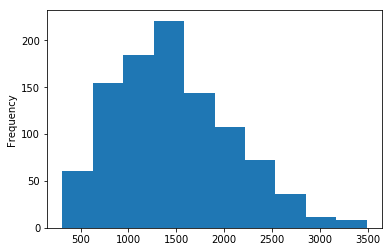

In [4]:
pd.Series(corpus).apply(len).plot(kind='hist')

Apply cleaning to help the model out.

In [5]:
bad_char_re = re.compile(r'[^-a-zA-Z0-9 !.,?\n:()]')
multi_spaces_re = re.compile(r'(\s){2,}')

def clean_description(description):
    filtered_description = bad_char_re.sub('', description)
    # Replace two or more spaces with one space
    filtered_description = multi_spaces_re.sub(r'\1\1', filtered_description)
    return filtered_description

cleaned_corpus = [clean_description(d) for d in corpus]
del corpus

Create a mapping of unique chars to integers

In [6]:
joined_corpus = '\n'.join(cleaned_corpus)
del cleaned_corpus
chars = sorted(list(set(joined_corpus)))
print(chars)
char_to_int = dict((c, i) for i, c in enumerate(chars))

['\n', ' ', '!', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Total number of characters in the corpus.

In [7]:
n_chars = len(joined_corpus)
print(n_chars)

1461861


Total number of characters in the vocab

In [8]:
n_vocab = len(chars)
print(n_vocab)

72


Prepare the dataset of input to output pairs encoded as integers

In [9]:
seq_length = 140
step = 1
data_x = []
data_y = []
for i in tqdm(range(0, n_chars - seq_length, step)):
    start = i
    end = i + seq_length
    seq_in = joined_corpus[start:end]
    seq_out = joined_corpus[end]
    data_x.append([char_to_int[char] for char in seq_in])
    data_y.append(char_to_int[seq_out])
n_patterns = len(data_x)
print(n_patterns)
del joined_corpus

100%|██████████| 1461721/1461721 [00:18<00:00, 80401.33it/s] 

1461721


Reshape the X array to be [samples, time steps, features], normalize, and one-hot encode the output

In [10]:
def transform_text_samples(text_samples, n_patterns, seq_length):
    return np.reshape(text_samples, (n_patterns, seq_length, 1)) / float(n_vocab)

X = transform_text_samples(data_x, n_patterns, seq_length)
y = keras.utils.np_utils.to_categorical(data_y)

Define the model

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True, implementation=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(128, return_sequences=True, implementation=2))
model.add(keras.layers.LSTM(128, implementation=2))
model.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

checkpoint_path = Path('models', 'weights-improvement-{epoch:02d}-{loss:.4f}.hdf5')
checkpoint = keras.callbacks.ModelCheckpoint(str(checkpoint_path), monitor='loss',
                                             verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [12]:
model.fit(X, y, epochs=60, batch_size=128, callbacks=callbacks_list)

Epoch 1/60
1461721/1461721 [==============================] - 1926s - loss: 2.9168  
Epoch 2/60
1461721/1461721 [==============================] - 1910s - loss: 2.6051  
Epoch 3/60
1461721/1461721 [==============================] - 1910s - loss: 2.4457  
Epoch 4/60
1461721/1461721 [==============================] - 1916s - loss: 2.3315  
Epoch 5/60
1461721/1461721 [==============================] - 1916s - loss: 2.2422  
Epoch 6/60
1461721/1461721 [==============================] - 1916s - loss: 2.1742  
Epoch 7/60
1461721/1461721 [==============================] - 1914s - loss: 2.1187  
Epoch 8/60
1461721/1461721 [==============================] - 1914s - loss: 2.0730  
Epoch 9/60
1461721/1461721 [==============================] - 1912s - loss: 2.0327  
Epoch 10/60
1461721/1461721 [==============================] - 1912s - loss: 1.9938  
Epoch 11/60
1461721/1461721 [==============================] - 1911s - loss: 1.9572  
Epoch 12/60
1461721/1461721 [==============================] - 

1461721/1461721 [==============================] - 1910s - loss: 1.6639  
Epoch 32/60
1461721/1461721 [==============================] - 1903s - loss: 1.6567  
Epoch 33/60
 227584/1461721 [===>..........................] - ETA: 1608s - loss: 1.6466

KeyboardInterrupt: 

In [13]:
filename = Path('models', 'weights-improvement-31-1.6567.hdf5')
model.load_weights(str(filename))
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

Generate a reverse mapping for ints to chars

In [14]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

Generate predictions from a seed sequence

In [15]:
start = np.random.randint(0, len(data_x)-1)
pattern = data_x[start]
print("Seed:\n{}".format(''.join([int_to_char[value] for value in pattern])))
num_generated_chars = 1000

def sample(preds, temperature=1.0):
    # sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds)
    return np.argmax(probas)

for diversity in (0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.2):
    generated_str = ''

    for i in range(num_generated_chars):
        x = transform_text_samples(pattern, 1, len(pattern))
        prediction = model.predict(x, verbose=0)
        index = sample(prediction[0], temperature=diversity)
        result = int_to_char[index]
        seq_in = [int_to_char[value] for value in pattern]
        generated_str += result
        pattern.append(index)
        pattern = pattern[1:]

    print("\n\nResult (diversity {}):\n{}".format(diversity, generated_str))

Seed:
Michael Thorton will carry consequences for his future and the fate of the world.
ABOUT THIS GAME
The critically-acclaimed and award-winning


Result (diversity 0.05):
 and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and complete and ceauh and ceauh in the complete and ceauh in the complete and the cester of the game in the complete and cester cetter cetter cetter complete and complete and complete and complete and complete and